In [1]:
# File system manangement
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

# my utility functions, see functions.py
from Utils.functions import *

-------------------------------------------------------------
- application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.

- bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
- bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
- previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
- POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
- credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
- installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

![alternative text](home_credit.png)

In [2]:
df_app_train_o = pd.read_csv('data/application_train.csv')
df_app_train = df_app_train_o.copy()
df_app_test = pd.read_csv('data/application_test.csv')
#df_bureau = pd.read_csv('data/bureau.csv')
#df_bureau_balance = pd.read_csv('data/bureau_balance.csv')
#df_prev_app = pd.read_csv('data/previous_application.csv')
#df_POS_CASH_balance = pd.read_csv('data/POS_CASH_balance.csv')
#df_credit_card_balance = pd.read_csv('data/credit_card_balance.csv')
#df_instal_payments = pd.read_csv('data/installments_payments.csv')

Optimisation de la mémoire :

In [3]:
gc.enable()

df_app_train = convert_types(df_app_train, print_info = True)
print('-------------------------')
df_app_test = convert_types(df_app_test, print_info = True)
print('-------------------------')

gc.collect()

Original Memory Usage: 0.3 gb.
New Memory Usage: 0.18 gb.
-------------------------
Original Memory Usage: 0.05 gb.
New Memory Usage: 0.03 gb.
-------------------------


0

In [4]:
df_HomeCredit_columns_description = pd.read_csv('data/HomeCredit_columns_description.csv', encoding = "ISO-8859-1") #utf-8 codec

In [5]:
def desc(col_name):
    print(f"{col_name} :")
    print(df_HomeCredit_columns_description[df_HomeCredit_columns_description['Row'] == col_name]['Description'])
    print("____________________________")

# Data
_______________________________________________________________

## app_train

In [6]:
df_app_train.shape

(307511, 122)

Le Dataframe d'entrainnement a 307511 individus et 122 features, dont la colomne 'TARGET'

## app_test

In [7]:
df_app_test.shape

(48744, 121)

In [8]:
df_app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Le DataFrame de test, a partir duquel nous devons predire notre jeu de données à envoyer à kaggle, a 48744 individus pour 121 features. Même features que pour app_train mais avec 'TARGET' en moins.

# Exploratory Data Analysis

-> Qu'est ce que le jeu de données peut nous dire ?

## Distribution de 'TARGET'

In [9]:
df_app_train['TARGET'].value_counts(normalize=True)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

<Axes: ylabel='proportion'>

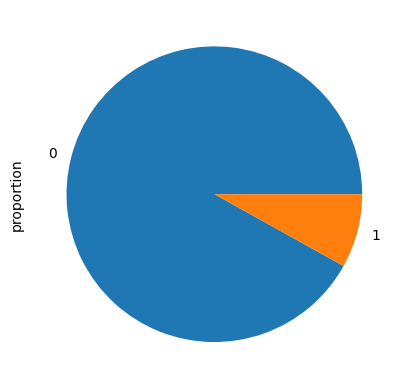

In [10]:
df_app_train['TARGET'].value_counts(normalize=True).plot(kind='pie')

Nous somme dans un cas de données désiquilibrés pour notre entrainement.  
À un moment nous utiliserons la technique `SMOTE` d'`imblearn`.  
Comme nous voulons garder nos données propre pour faire du feature engineering pour le moment, nous traiterons ce probleme plus tard.

## Données manquantes

In [11]:
def show_missing_values(df, sample_size=1000, show_first=20):
    msno.matrix(df_app_test.sample(sample_size))

    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    miss_col_name = '% of Total Missing Values'
    
    mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : miss_col_name})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
                mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
                miss_col_name , ascending=False).round(2)
    
    print ("Ce dataframe a " + str(df.shape[1]) + " colonnes.\n"      
        "Il y a " + str(mis_val_table_ren_columns.shape[0]) +
        " colonnes avec des valeurs manquantes.")
    
    mis_val_table_ren_columns.reset_index()
    print(mis_val_table_ren_columns.head(show_first))

### app_train

In [12]:
df_app_train['TARGET'].isnull().sum()

0

Ce dataframe a 122 colonnes.
Il y a 67 colonnes avec des valeurs manquantes.
                          Missing Values  % of Total Missing Values
COMMONAREA_MEDI                   214865                      69.87
COMMONAREA_AVG                    214865                      69.87
COMMONAREA_MODE                   214865                      69.87
NONLIVINGAPARTMENTS_MEDI          213514                      69.43
NONLIVINGAPARTMENTS_MODE          213514                      69.43
NONLIVINGAPARTMENTS_AVG           213514                      69.43
FONDKAPREMONT_MODE                210295                      68.39
LIVINGAPARTMENTS_MODE             210199                      68.35
LIVINGAPARTMENTS_MEDI             210199                      68.35
LIVINGAPARTMENTS_AVG              210199                      68.35
FLOORSMIN_MODE                    208642                      67.85
FLOORSMIN_MEDI                    208642                      67.85
FLOORSMIN_AVG                     20864

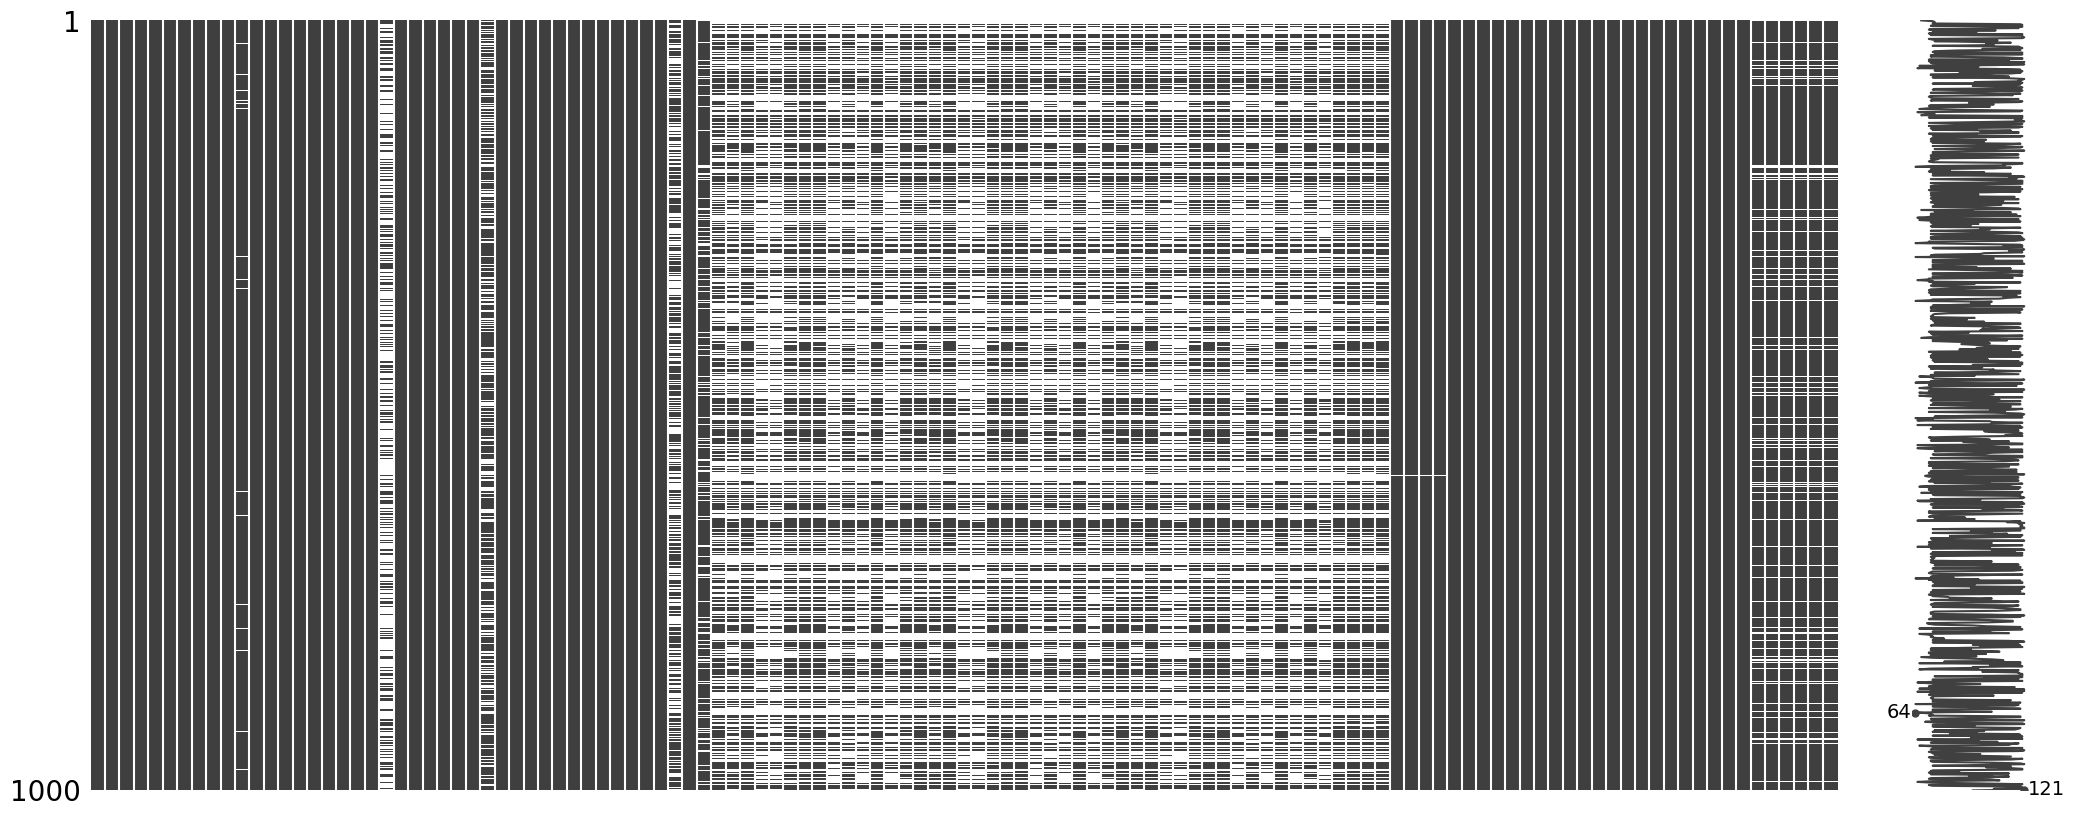

In [13]:
show_missing_values(df_app_train)

### app_test

Ce dataframe a 121 colonnes.
Il y a 64 colonnes avec des valeurs manquantes.
                          Missing Values  % of Total Missing Values
COMMONAREA_MODE                    33495                      68.72
COMMONAREA_MEDI                    33495                      68.72
COMMONAREA_AVG                     33495                      68.72
NONLIVINGAPARTMENTS_MEDI           33347                      68.41
NONLIVINGAPARTMENTS_AVG            33347                      68.41
NONLIVINGAPARTMENTS_MODE           33347                      68.41
FONDKAPREMONT_MODE                 32797                      67.28
LIVINGAPARTMENTS_MODE              32780                      67.25
LIVINGAPARTMENTS_MEDI              32780                      67.25
LIVINGAPARTMENTS_AVG               32780                      67.25
FLOORSMIN_MEDI                     32466                      66.61
FLOORSMIN_MODE                     32466                      66.61
FLOORSMIN_AVG                      3246

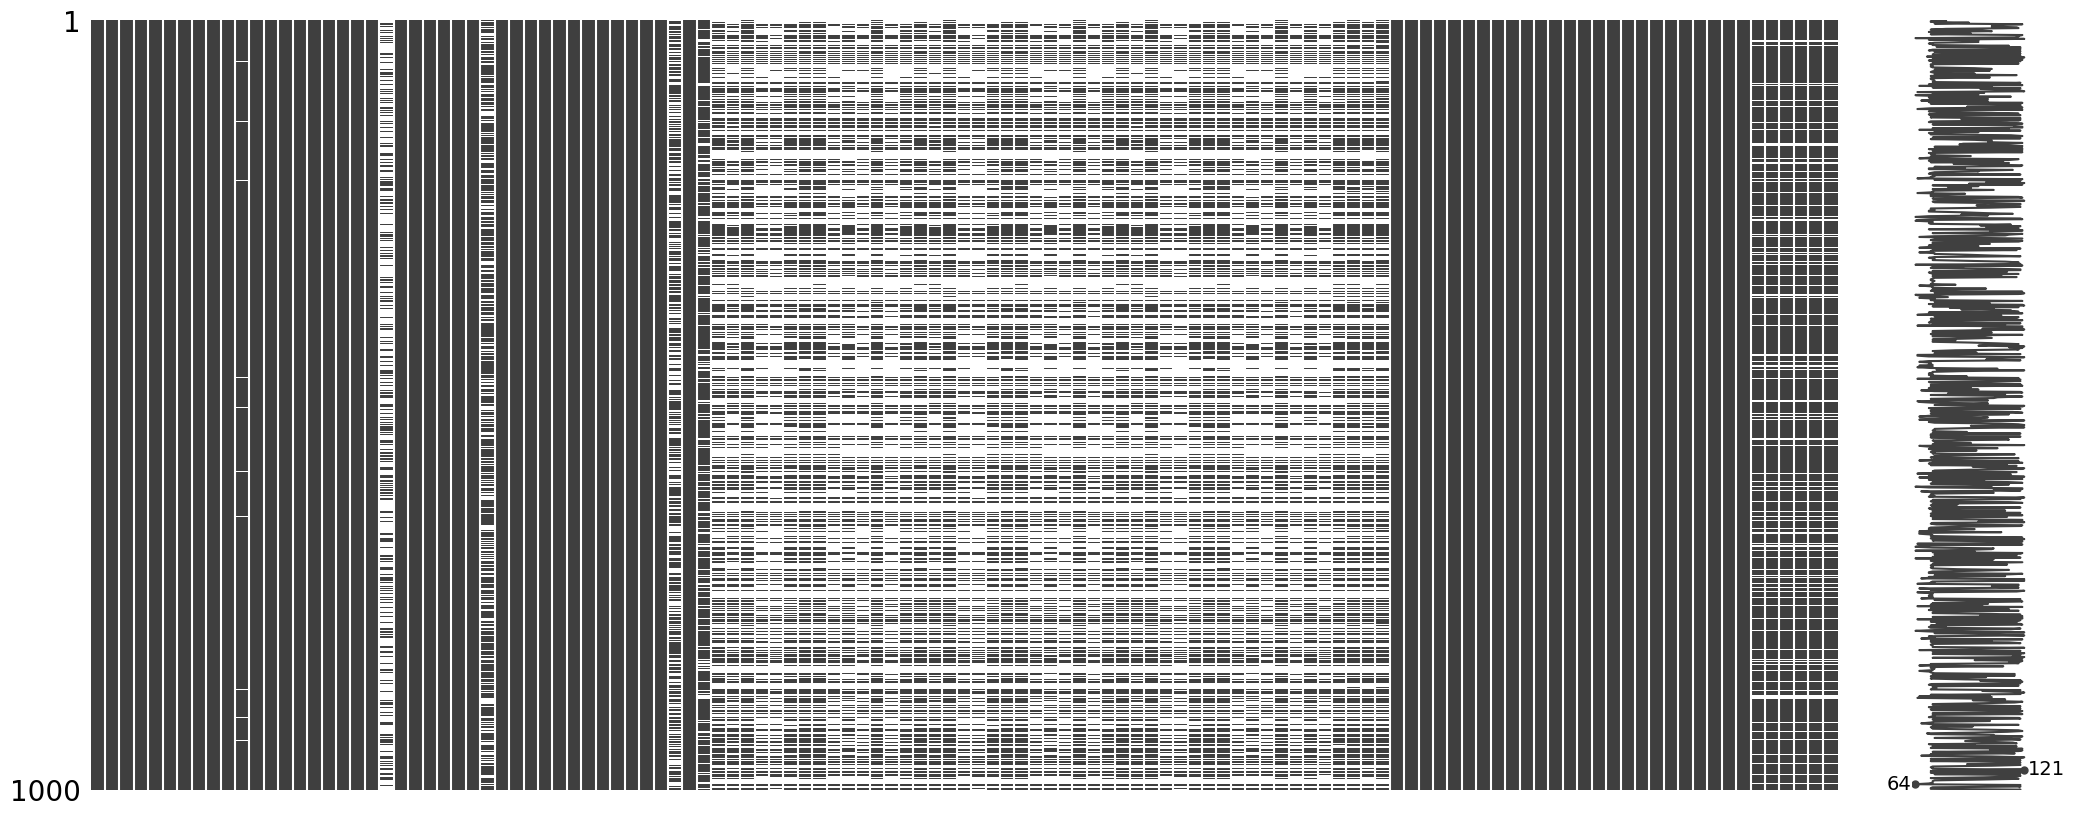

In [14]:
show_missing_values(df_app_test)

Nous avons beaucoup de valeures manquantes dans nos dataframe de train et de test.  
Nous pourrions nous débarasser des colonnes qui dépassent un certain pourcentage de valeurs manquantes.  
Cependant, nous ne pouvons pas savoir en avance si ces variables seront utile ou non à nos modèles, nous nous occuperons donc de l'imputation plus tard, si le besoin y est.  
De plus, certains des modèles que nous testerons (dont `XGBoost`) peuvent gérer les valeurs manquantes sans avoir besoin de faire d'imputation.  
  
Nous gardons donc ces colonnes pour le moments.

## Types des variables

In [15]:
df_app_train.dtypes.value_counts()

float32     65
int64       40
category     2
int32        1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
Name: count, dtype: int64

Nous avons 65 + 41 variables quantitatives et 16 variables qualitatives

In [16]:
df_app_train.select_dtypes('category').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [17]:
df_app_test.select_dtypes('category').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Nous avons surtout des varibales catégorielles avec peu d'uniques, voyons un peu comment nous pouvons transformer ces varibales pour les utiliser dans nos futurs modèles.

## Encoding 

### Label Encoding et One-Hot Encoding

Nous avons ici la possibilité d'utiliser 2 méthodes d'encoding.  
Le `Label Encoding` est le plus simple, assigne un nombre pour chaque valeures, mais a la particularité d'imposer un ordre (classement) arbitraire entre différentes valeures d'une même catégorie, ce qui peut poser un problème avec certains modèles de machine learning (certains gèrent très bien le `Label Encoding`).  
Le `One-Hot Encoding` crée une nouvelle variables binaire pour chaque valeurs d'une meme catégorie. C'est une méthode plus sûr, mais qui peut faire exploser le nombre de variiables avec lequel nous travaillons.  
  
Nous allons utiliser le `Label Encoding` pour les variables qualitatives avec 2 valeurs max, et le `One-Hot Encoding` pour les autres.  
Il sera possible plus tard d'effectuer une reduction de dimensions par ACP (ou autres techniques) si le besoin s'en fait sentir.

In [18]:
le = LabelEncoder()
le_count = 0

# On part du principe que test et train ont les mêmes colonnes
for col in df_app_train:
    if df_app_train[col].dtype == 'category':
        # If 2 or fewer unique categories
        if (len(list(df_app_train[col].unique())) <= 2) & (len(list(df_app_test[col].unique())) <= 2):
            le.fit(df_app_train[col])
            df_app_train[col] = le.transform(df_app_train[col])
            le.fit(df_app_test[col])
            df_app_test[col] = le.transform(df_app_test[col])
            le_count += 1
            
print('%d colonnes ont été labelisé.' % le_count)

3 colonnes ont été labelisé.


In [19]:
# one-hot encoding pour le reste
df_app_train = pd.get_dummies(df_app_train)
df_app_test = pd.get_dummies(df_app_test)

print('Training Features shape: ', df_app_train.shape)
print('Testing Features shape: ', df_app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


Nos dataframes de train et de test ne sont plus alignés, il faut les réaligner :

In [20]:
train_labels = df_app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
df_app_train, df_app_test = df_app_train.align(df_app_test, join = 'inner', axis = 1)

# Add the target back in
df_app_train['TARGET'] = train_labels

print('Training Features shape: ', df_app_train.shape)
print('Testing Features shape: ', df_app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


In [21]:
df_app_train.head(25)

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002,0,0,1,0,202500.00000,406597.5,24700.5,351000.0,0.018801,...,False,False,False,False,False,True,False,True,False,1
1,100003,0,0,0,0,270000.00000,1293502.5,35698.5,1129500.0,0.003541,...,True,False,False,False,False,False,False,True,False,0
2,100004,1,1,1,0,67500.00000,135000.0,6750.0,135000.0,0.010032,...,False,False,False,False,False,False,False,False,False,0
3,100006,0,0,1,0,135000.00000,312682.5,29686.5,297000.0,0.008019,...,False,False,False,False,False,False,False,False,False,0
4,100007,0,0,1,0,121500.00000,513000.0,21865.5,513000.0,0.028663,...,False,False,False,False,False,False,False,False,False,0
5,100008,0,0,1,0,99000.00000,490495.5,27517.5,454500.0,0.035792,...,False,False,False,False,False,False,False,False,False,0
6,100009,0,1,1,1,171000.00000,1560726.0,41301.0,1395000.0,0.035792,...,False,False,False,False,False,False,False,False,False,0
7,100010,0,1,1,0,360000.00000,1530000.0,42075.0,1530000.0,0.003122,...,False,False,False,False,False,False,False,False,False,0
8,100011,0,0,1,0,112500.00000,1019610.0,33826.5,913500.0,0.018634,...,False,False,False,False,False,False,False,False,False,0
9,100012,1,0,1,0,135000.00000,405000.0,20250.0,405000.0,0.019689,...,False,False,False,False,False,False,False,False,False,0


## Anomalies

In [22]:
list_col_to_check = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_CHILDREN']

In [23]:
def plot_and_describe(df, col_name):
    print(col_name)
    print(df[col_name].describe())
    sns.boxplot(x=col_name, data=df_app_train, color='orange')
    plt.title(col_name)
    plt.show()
    df_app_train[col_name].plot.hist(title = f"{col_name} Histogram", color ='orange', )
    plt.xlabel(col_name)
    plt.show()
    print('__________________________________________')
    

DAYS_BIRTH
count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64


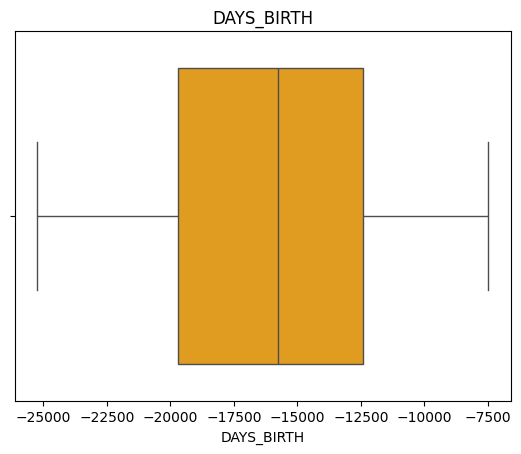

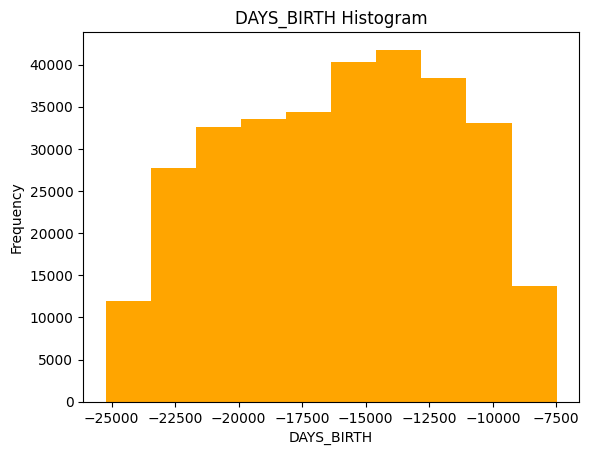

__________________________________________
DAYS_EMPLOYED
count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64


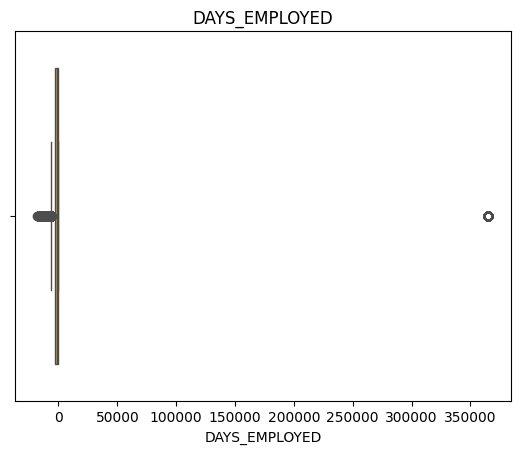

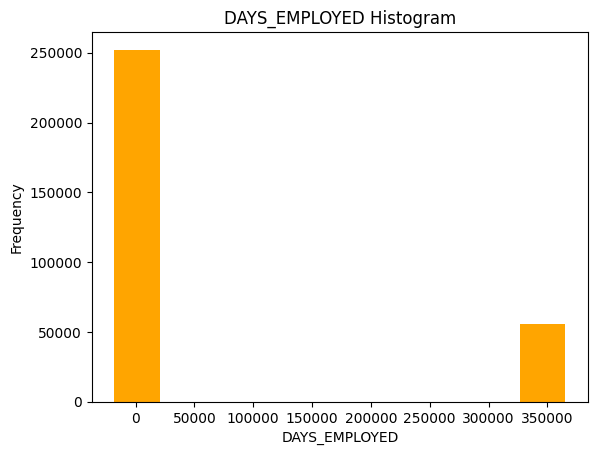

__________________________________________
CNT_CHILDREN
count    307511.000000
mean          0.417052
std           0.722121
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: CNT_CHILDREN, dtype: float64


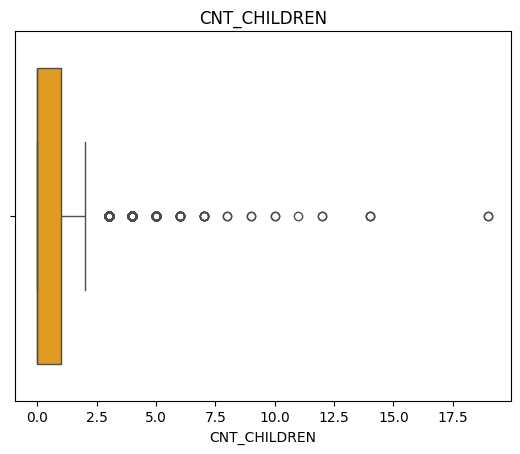

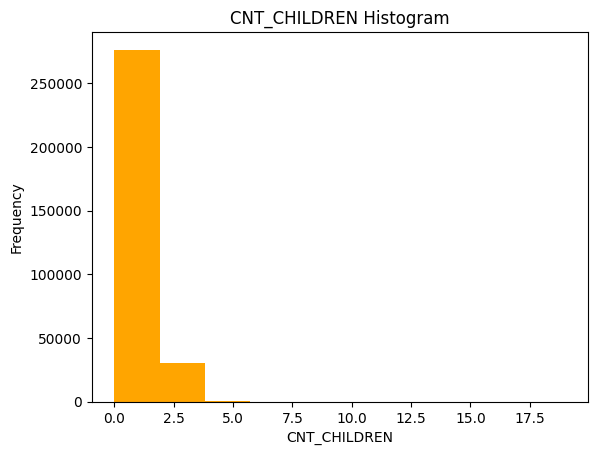

__________________________________________


In [24]:
for col in list_col_to_check:
    plot_and_describe(df_app_train, col)

DAYS_BIRTH et CNT_CHILDREN semble avoir des données cohérentes. Mais la répartition de DAYS_EMPLOYED ne va pas, il y 'a beaucoup de valeur > 300.000. Traitons ces cas :

In [25]:
anomalies_days_employed = df_app_train[df_app_train['DAYS_EMPLOYED'] > 300000]
anomalies_days_employed['DAYS_EMPLOYED'].sort_values() 

8         365243
204976    365243
204994    365243
204995    365243
204998    365243
           ...  
103386    365243
103398    365243
103422    365243
103344    365243
307507    365243
Name: DAYS_EMPLOYED, Length: 55374, dtype: int64

Elles ont toutes la même valeure pour `DAYS_EMPLOYED`, 365243 (jours). Il s'agit peut être d'un bug. Cette valeur represente un nombre significatif de notre échantillon, 55374 individus, nous ne pouvons pas simplement les retirer car il nous servirons quand même dans nos algorithmes de machine learning.

Juste par curiosité, cherchons s'il y a un point commun etre ces individus.

<Axes: ylabel='Frequency'>

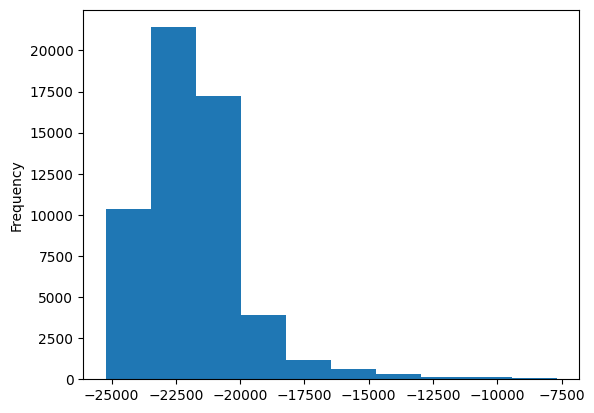

In [26]:
anomalies_days_employed['DAYS_BIRTH'].plot.hist()

L'age ne semble pas avoir de lien. Mais il y'a a surtout des personnes agés dans les anomalies alors que nous avions une répartion plus lisse des ages dans l'échantillon total.

<Axes: ylabel='Frequency'>

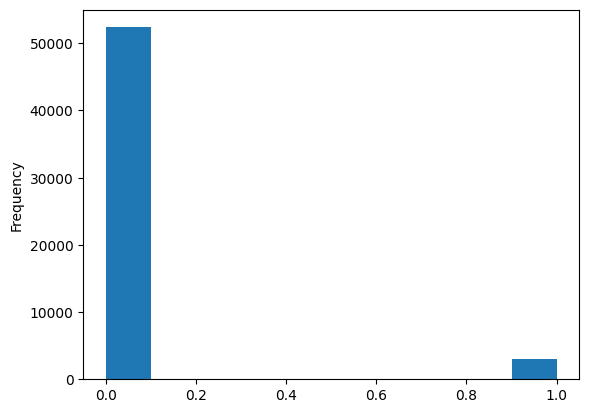

In [27]:
anomalies_days_employed['TARGET'].plot.hist()

Voyons la répartition de TARGET en fonction des anomalies que nous observons

In [28]:
non_anom = df_app_train[df_app_train['DAYS_EMPLOYED'] != 365243]
percent_default_non_anom = 100 * non_anom['TARGET'].mean().__round__(2)
percent_default_anom = 100 * anomalies_days_employed['TARGET'].mean().__round__(2)
print(f'La moyenne de défault de paiement dans les anomalies est de {percent_default_anom}%')
print(f'La moyenne de défault de paiement dans les non-anomalies est de {percent_default_non_anom}%')

La moyenne de défault de paiement dans les anomalies est de 5.0%
La moyenne de défault de paiement dans les non-anomalies est de 9.0%


Il y'a presque 2 fois moins de default de paiement dans les anomalies que nous avons relevé.

Je ne trouve pas de point commun entre ces anomalies, peut être ont elles toutes été crée dans la même agence dans un range de date précis ?  

Pour gérer ces anomalies, nous allons les remplacer par des nan. Nous verrons plus tard comment nous gerrerons l'imputation de ces valeures.  
Parce que ces individus ont des informations qui nous servirons, nous allons garder la trace du fait que ces individus étaient des anomalies, juste au cas où :

In [29]:
df_app_train['DAYS_EMPLOYED_FLAG_ANOM'] = df_app_train['DAYS_EMPLOYED'] == 365243

df_app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

DAYS_EMPLOYED
count    252137.000000
mean      -2384.169325
std        2338.360162
min      -17912.000000
25%       -3175.000000
50%       -1648.000000
75%        -767.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64


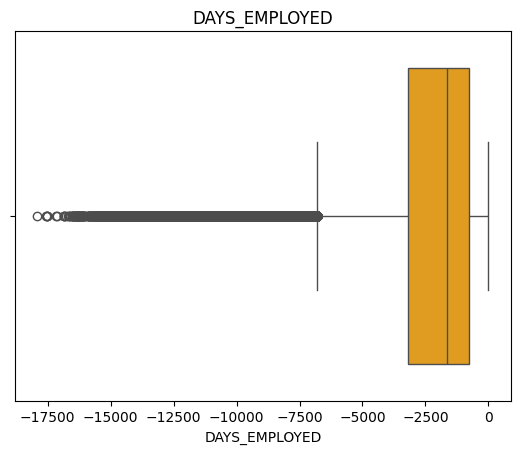

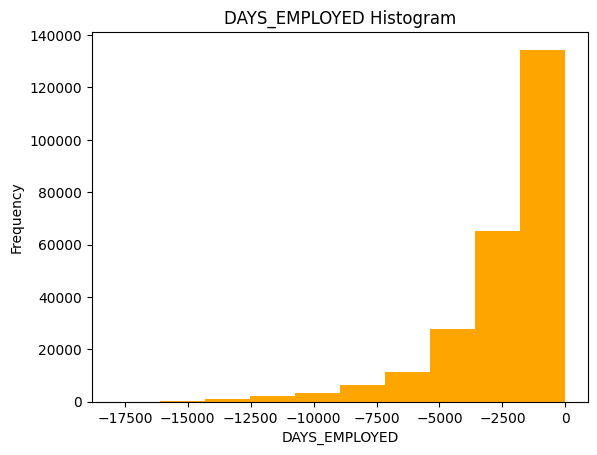

__________________________________________


In [30]:
plot_and_describe(df_app_train, 'DAYS_EMPLOYED')

Le comportement de la distribution de `DAYS_EMPLOYED` est maintenant beaucoup plus logique.  
Appliquons nos changement dans `df_app_test` car les deux BDD doivent avoir la même structure.

In [31]:
df_app_test['DAYS_EMPLOYED_FLAG_ANOM'] = df_app_test['DAYS_EMPLOYED'] == 365243

df_app_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

### `AGE_START_WORK`

Voyons aussi 'DAYS_EMPLOYED' mis en rapport avec `DAYS_BIRTH`, pour voir s'il n'y a pas de valeurs impossibles. Partons du principe qu'aucunne de ces personnes ne travaillent aavant l'age de 15 ans (il y aura peut etre quelques exceptions).

In [32]:
df_app_train['AGE_START_WORK'] = (abs(df_app_train['DAYS_BIRTH']) - abs(df_app_train['DAYS_EMPLOYED']))
#df_too_young_to_work = df_app_train.loc[(abs(df_app_train['DAYS_BIRTH']) < (df_app_train['DAYS_EMPLOYED']))]
df_app_train['AGE_START_WORK'] = df_app_train['AGE_START_WORK'] / 365


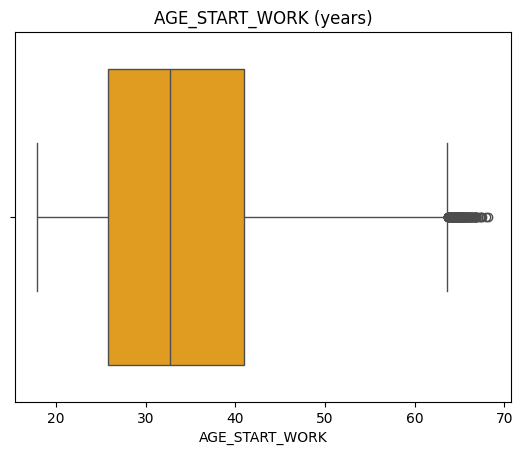

In [33]:
sns.boxplot(x='AGE_START_WORK', data=df_app_train, color='orange')
plt.title('AGE_START_WORK (years)')
plt.show()

Rien d'anormal

In [34]:
df_app_train.drop(columns = ['AGE_START_WORK'], inplace=True)

## Correlations :

Nous allons jetter un coup d'oeil à la table de corrélation de notre BDD en fonction de la variable `TARGET`

In [35]:
corr_table = df_app_train.corr()['TARGET'].sort_values()

Les coéfdicients de pearsons contenu dans cette table peuvent nous aider à avoir un premier avis sur les variables qui influent sur la target.

In [36]:
#positively corr
corr_table.reset_index()
corr_table = corr_table.sort_values(ascending=False)
print(corr_table.head(20))

TARGET                                               1.000000
DAYS_BIRTH                                           0.078239
DAYS_EMPLOYED                                        0.074958
REGION_RATING_CLIENT_W_CITY                          0.060893
REGION_RATING_CLIENT                                 0.058899
NAME_INCOME_TYPE_Working                             0.057481
DAYS_LAST_PHONE_CHANGE                               0.055218
CODE_GENDER_M                                        0.054713
DAYS_ID_PUBLISH                                      0.051457
REG_CITY_NOT_WORK_CITY                               0.050994
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
FLAG_EMP_PHONE                                       0.045982
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_DOCUMENT_3                                      0.044346
OCCUPATION_TYPE_Laborers                             0.043019
DAYS_REGISTRATION                                    0.041975
OWN_CAR_

Les 5 variables les plus corrélés positivement à `TARGET` sont `DAYS_EMPLOYED`, `REGION_RATING_CLIENT_W_CITY`, `DAYS_BIRTH`, `REGION_RATING_CLIENT` et `NAME_EDUCATION_TYPE_Secondary / secondary special`.  
La documentation nous informe que :
- `DAYS_EMPLOYED` : "How many days before the application the person started current employment"
- `REGION_RATING_CLIENT_W_CITY` : "Our rating of the region where client lives with taking city into account (1,2,3)"
- `DAYS_BIRTH` : "Client's age in days at the time of application"
- `REGION_RATING_CLIENT` : Our rating of the region where client lives (1,2,3)
- `NAME_EDUCATION_TYPE` (encoded) : "Level of highest education the client achieved"

Donc si on devait résumer grossièrement, on apprends que <u>à priori et selon les statistiques présentes dans ces bases de données</u>, la capacité de remboursement d'une personne dépends en premier lieu : 
- de son ancienneté dans sons entreprise actuelle
- d'une note arbitraire en fonction de la region et de la ville où vit l'individu (++)
- de son age
- de son niveau d'étude

Nous étudierons les relations de ces variables à TARGET juste après.

> **Note** : `DAYS_BIRTH` Contient des valeurs négatives, que nous passerons en absolues. Mais celà signifierait que plus une personne est agée, plus elle serait en capacité de rembourser son pret à temps.

In [37]:
#negatively corr
corr_table = corr_table.sort_values(ascending=True)
print(corr_table.head(20))

EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
DAYS_EMPLOYED_FLAG_ANOM                -0.045987
ORGANIZATION_TYPE_XNA                  -0.045987
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
FLOORSMAX_MODE                         -0.043226
EMERGENCYSTATE_MODE_No                 -0.042201
HOUSETYPE_MODE_block of flats          -0.040594
AMT_GOODS_PRICE                        -0.039645
REGION_POPULATION_RELATIVE             -0.037227
ELEVATORS_AVG                          -0.034199
ELEVATORS_MEDI                         -0.033863
FLOORSMIN_AVG                          -0.033614
FLOORSMIN_MEDI                         -0.033394
WALLSMATERIAL_MODE_Panel               -0.033119
Name: TARGET, dtype:

Les 5 variables les plus corrélés négativement à `TARGET` sont `EXT_SOURCE_3`, `EXT_SOURCE_2`, `EXT_SOURCE_1`, `AMT_GOODS_PRICE` et `NAME_EDUCATION_TYPE_Higher education`.  
La documentation nous informe que :
- `EXT_SOURCE_3` : "Normalized score from external data source"
- `EXT_SOURCE_2` : "Normalized score from external data source"
- `EXT_SOURCE_1` : "Normalized score from external data source"
- `AMT_GOODS_PRICE` : For consumer loans it is the price of the goods for which the loan is given
- `NAME_EDUCATION_TYPE` (encoded) : "Level of highest education the client achieved"

### DAYS_EMPLOYED

In [38]:
df_app_train['DAYS_EMPLOYED'] = abs(df_app_train['DAYS_EMPLOYED'])
df_app_test['DAYS_EMPLOYED'] = abs(df_app_test['DAYS_EMPLOYED'])

Text(0, 0.5, 'Count')

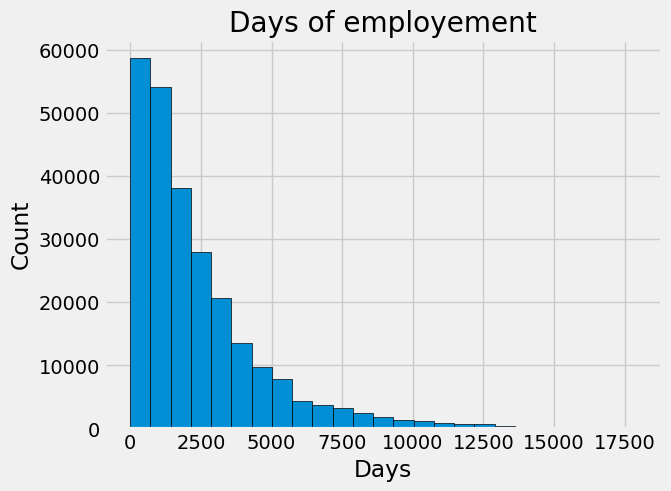

In [39]:
plt.style.use('fivethirtyeight')
plt.hist(df_app_train['DAYS_EMPLOYED'], edgecolor = 'k', bins = 25)
plt.title('Days of employement')
plt.xlabel('Days')
plt.ylabel('Count')

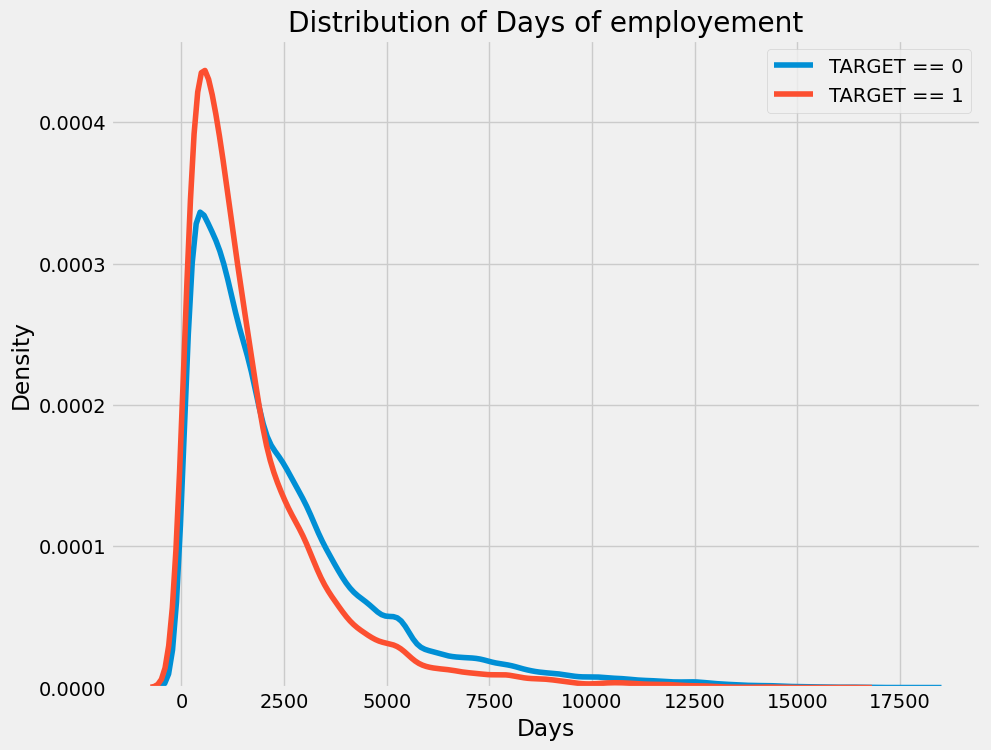

In [40]:
plt.figure(figsize = (10, 8))
sns.kdeplot(df_app_train.loc[df_app_train['TARGET'] == 0, 'DAYS_EMPLOYED'], label = 'TARGET == 0')
sns.kdeplot(df_app_train.loc[df_app_train['TARGET'] == 1, 'DAYS_EMPLOYED'], label = 'TARGET == 1')
plt.xlabel('Days'); plt.ylabel('Density'); plt.title('Distribution of Days of employement');
plt.legend()
plt.show()

On observe une densité plus haute de défaut de remboursement pour les individus qui sont employé depuis moins de ~2000 jours, par rapport à la densité d'individus qui ne font pas de défauts.  
Voyons la moyenne des défauts par tranches de `DAYS_EMPLOYED` :

In [41]:
employed_data = df_app_train[['TARGET', 'DAYS_EMPLOYED']]
employed_data['DAYS_EMPLOYED_BINNED'] = pd.cut(employed_data['DAYS_EMPLOYED'], bins = np.linspace(0, 17500, num = 11))
employed_data.head(10)

,TARGET,DAYS_EMPLOYED,DAYS_EMPLOYED_BINNED
0,1,637.0,"(0.0, 1750.0]"
1,0,1188.0,"(0.0, 1750.0]"
2,0,225.0,"(0.0, 1750.0]"
3,0,3039.0,"(1750.0, 3500.0]"
4,0,3038.0,"(1750.0, 3500.0]"
5,0,1588.0,"(0.0, 1750.0]"
6,0,3130.0,"(1750.0, 3500.0]"
7,0,449.0,"(0.0, 1750.0]"
8,0,NaN,NaN
9,0,2019.0,"(1750.0, 3500.0]"


In [42]:
employed_groups  = employed_data.groupby('DAYS_EMPLOYED_BINNED').mean()
employed_groups

,TARGET,DAYS_EMPLOYED
DAYS_EMPLOYED_BINNED,,
"(0.0, 1750.0]",0.106298,836.053002
"(1750.0, 3500.0]",0.075121,2527.274109
"(3500.0, 5250.0]",0.058365,4266.514246
"(5250.0, 7000.0]",0.050588,5983.151929
"(7000.0, 8750.0]",0.046781,7770.907171
"(8750.0, 10500.0]",0.041854,9545.562640
"(10500.0, 12250.0]",0.046414,11287.216596
"(12250.0, 14000.0]",0.021145,12957.839648
"(14000.0, 15750.0]",0.017241,14684.614943


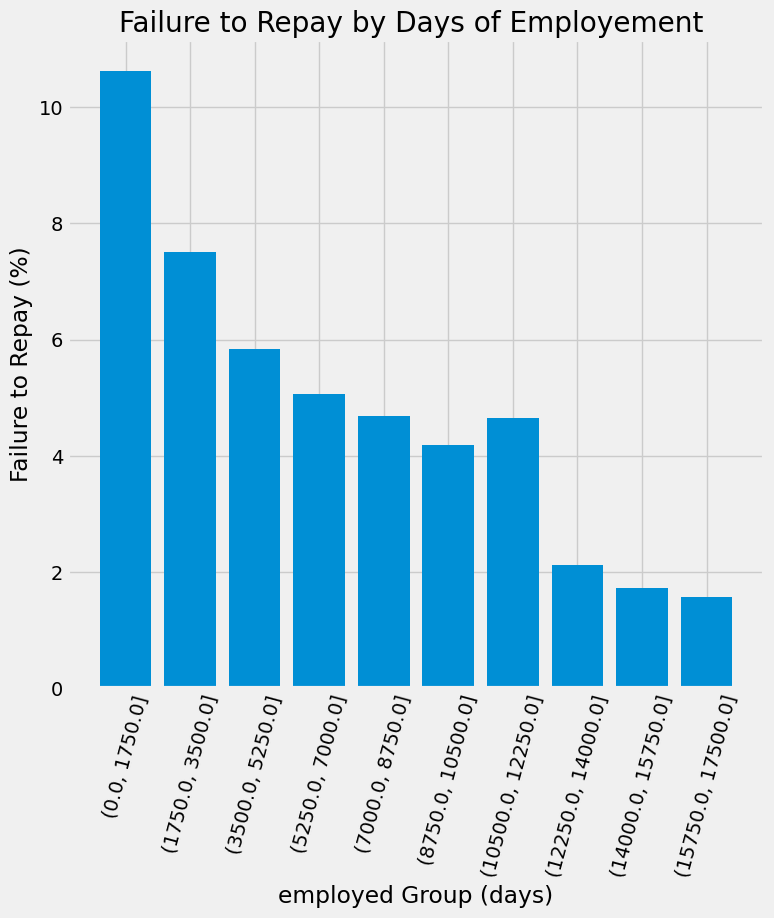

In [43]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(employed_groups.index.astype(str), 100 * employed_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75)
plt.xlabel('employed Group (days)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Days of Employement ');

On a clairement une tendance ici. Les individus qui sont employés depuis moins longtemps ont moins de chance de rembourser leur crédit à temps. Cette variable servira à nos algorithmes de machine learning.  
C'est une donné qui peut être utilisé par la banque, ça ne veut pas dire qu'il faut discriminer ces individus là, mais que des précautions peuvent être mis en place pour aider ceux là à rembourser à temps.

### DAYS_BIRTH

Faisons exactement la même chose que pour `DAYS_EMPLOYED`

In [44]:
df_app_train['DAYS_BIRTH'] = abs(df_app_train['DAYS_BIRTH'])
#df_app_train['YEARS_BIRTH'] = abs(df_app_train['DAYS_BIRTH'] / 365)
df_app_test['DAYS_BIRTH'] = abs(df_app_test['DAYS_BIRTH'])
#df_app_test['YEARS_BIRTH'] = abs(df_app_test['DAYS_BIRTH'] / 365)

Text(0, 0.5, 'Count')

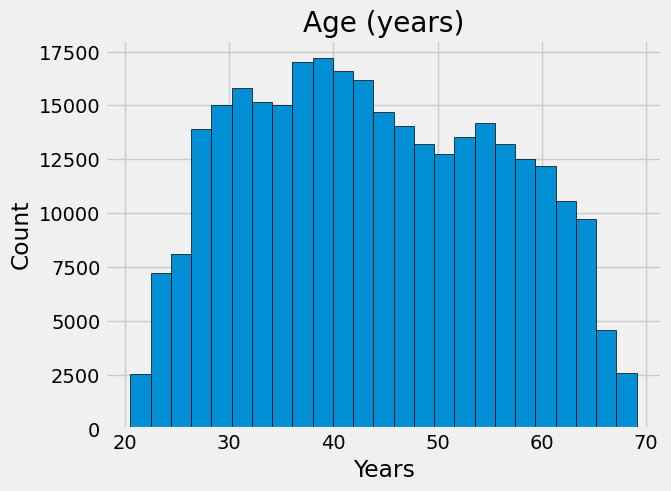

In [45]:
plt.style.use('fivethirtyeight')
plt.hist(df_app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age (years)')
plt.xlabel('Years')
plt.ylabel('Count')

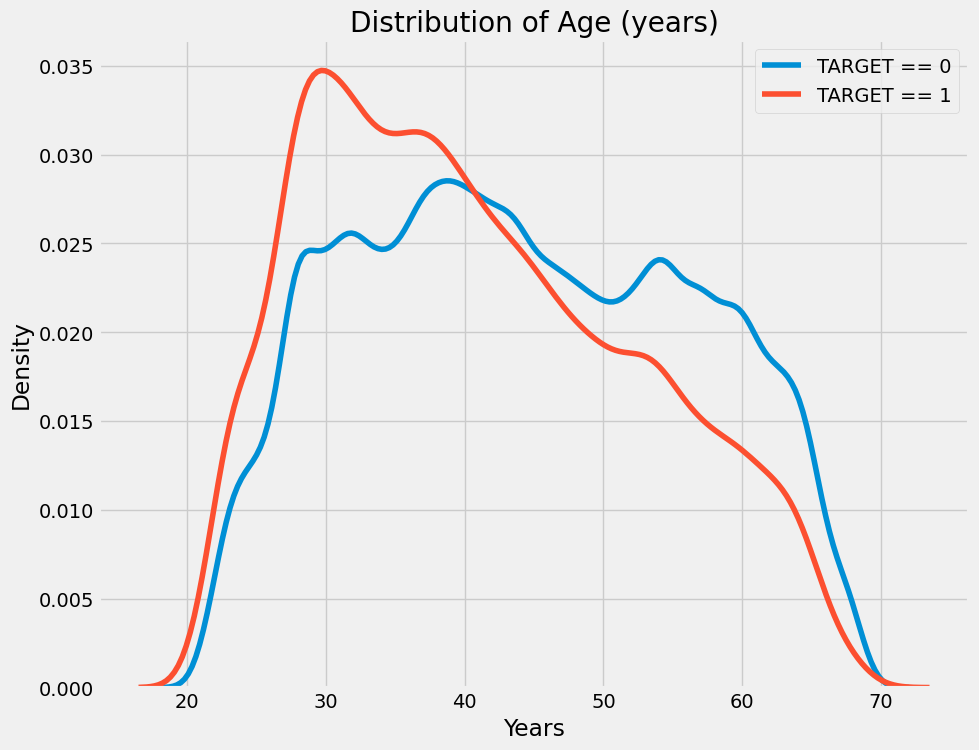

In [46]:
plt.figure(figsize = (10, 8))
sns.kdeplot(df_app_train.loc[df_app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'TARGET == 0')
sns.kdeplot(df_app_train.loc[df_app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'TARGET == 1')
plt.xlabel('Years'); plt.ylabel('Density'); plt.title('Distribution of Age (years)');
plt.legend()
plt.show()

In [47]:
age_data = df_app_train[['TARGET', 'DAYS_BIRTH']]
age_data['AGE_BINNED'] = pd.cut(age_data['DAYS_BIRTH'] / 365, bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,AGE_BINNED
0,1,9461,"(25.0, 30.0]"
1,0,16765,"(45.0, 50.0]"
2,0,19046,"(50.0, 55.0]"
3,0,19005,"(50.0, 55.0]"
4,0,19932,"(50.0, 55.0]"
5,0,16941,"(45.0, 50.0]"
6,0,13778,"(35.0, 40.0]"
7,0,18850,"(50.0, 55.0]"
8,0,20099,"(55.0, 60.0]"
9,0,14469,"(35.0, 40.0]"


In [48]:
age_groups  = age_data.groupby('AGE_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH
AGE_BINNED,,
"(20.0, 25.0]",0.123036,8532.795625
"(25.0, 30.0]",0.111436,10155.219250
"(30.0, 35.0]",0.102814,11854.848377
"(35.0, 40.0]",0.089414,13707.908253
"(40.0, 45.0]",0.078491,15497.661233
"(45.0, 50.0]",0.074171,17323.900441
"(50.0, 55.0]",0.066968,19196.494791
"(55.0, 60.0]",0.055314,20984.262742
"(60.0, 65.0]",0.052737,22780.547460


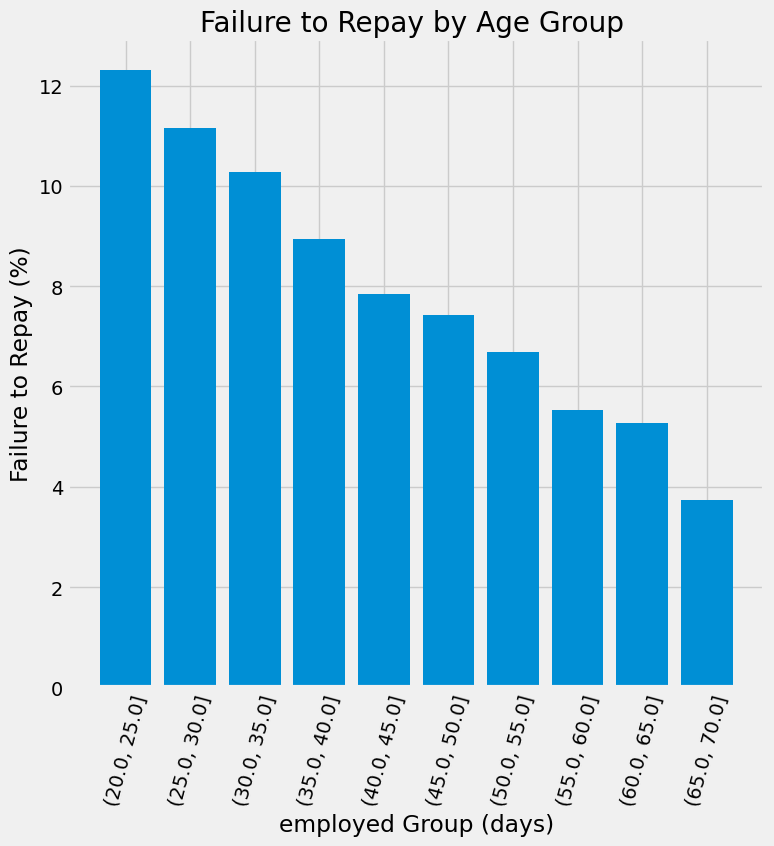

In [49]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75)
plt.xlabel('employed Group (days)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group ');

De la même façon, on observe bien une tendance ici. Les plus jeunes ont plus tendance à faire des défauts de paiement.  
Cette donnée servira autant les banques à prendre des décisions que nos algorithmes.

### REGION_RATING_CLIENT_W_CITY

In [50]:
df_app_train_o['REGION_RATING_CLIENT_W_CITY'].unique()

array([2, 1, 3], dtype=int64)

Text(0, 0.5, 'Count')

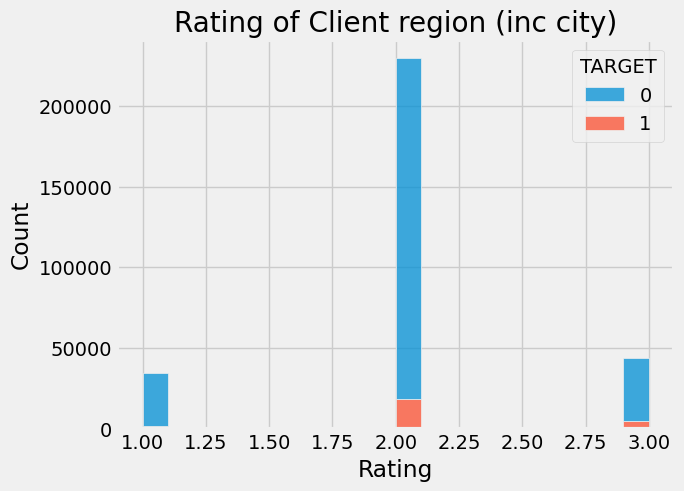

In [51]:
plt.style.use('fivethirtyeight')
sns.histplot(data=df_app_train, x='REGION_RATING_CLIENT_W_CITY', hue = 'TARGET', multiple='stack')
plt.title('Rating of Client region (inc city)')
plt.xlabel('Rating')
plt.ylabel('Count')

In [52]:
rating_region_city_data = df_app_train[['TARGET', 'REGION_RATING_CLIENT_W_CITY']]
rating_region_city_groups = rating_region_city_data.groupby('REGION_RATING_CLIENT_W_CITY').mean()
rating_region_city_groups

,TARGET
REGION_RATING_CLIENT_W_CITY,
1,0.048409
2,0.079178
3,0.114022


<Axes: xlabel='REGION_RATING_CLIENT_W_CITY'>

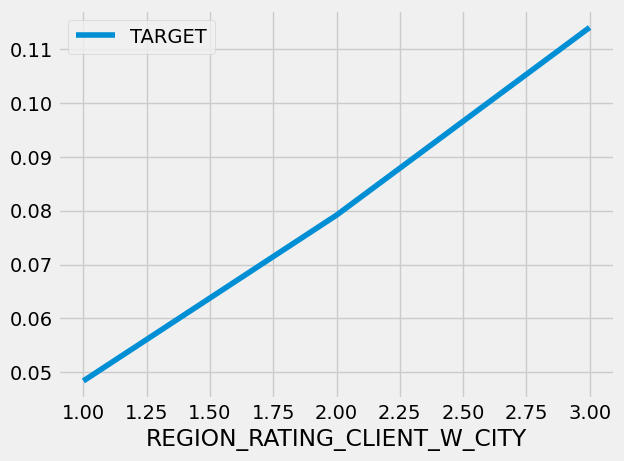

In [53]:
rating_region_city_groups.plot()

De même, la note donné au client en fonction de la région et de la ville où il habite a clairement une importance. Ceux qui sont notés 3 ont 2 jfois plus de chance de faire un défaut de paiement que ceux qui sont noté 1.

### REGION_RATING_CLIENT

In [54]:
df_app_train_o['REGION_RATING_CLIENT'].unique()

array([2, 1, 3], dtype=int64)

Text(0, 0.5, 'Count')

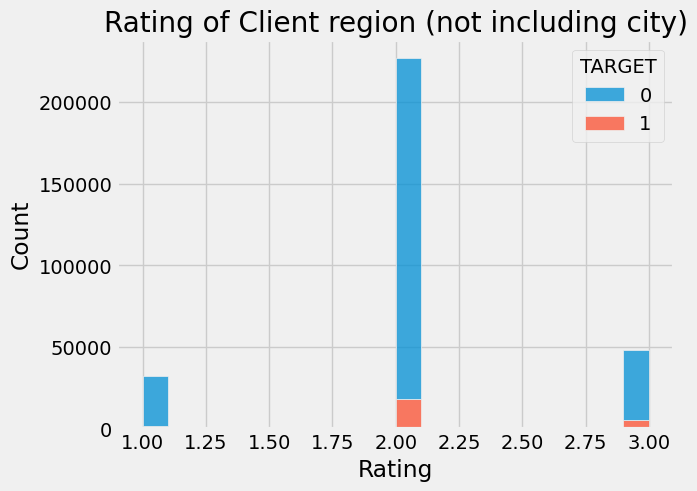

In [55]:
plt.style.use('fivethirtyeight')
sns.histplot(data=df_app_train, x='REGION_RATING_CLIENT', hue='TARGET', multiple='stack')
plt.title('Rating of Client region (not including city)')
plt.xlabel('Rating')
plt.ylabel('Count')

In [56]:
rating_region_data = df_app_train[['TARGET', 'REGION_RATING_CLIENT']]
rating_region_groups = rating_region_data.groupby('REGION_RATING_CLIENT').mean()
rating_region_groups

,TARGET
REGION_RATING_CLIENT,
1,0.048203
2,0.078891
3,0.111028


<Axes: xlabel='REGION_RATING_CLIENT'>

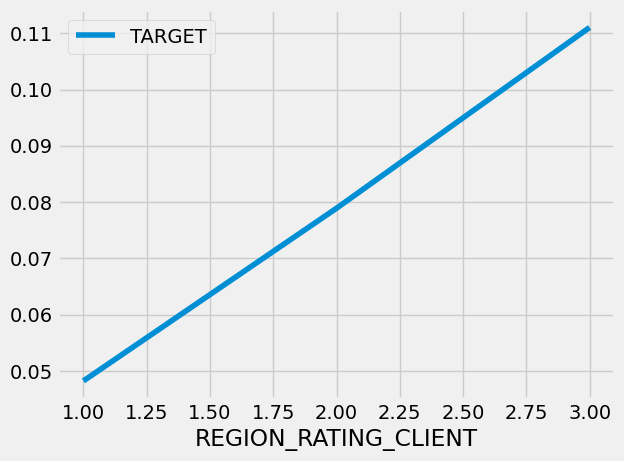

In [57]:
rating_region_groups.plot()


Même conclusions que pour la variable précédente.

### NAME_EDUCATION_TYPE

(Comme nous avons encodé cette variable, nous ferons nos observation sur le dataframe original pour plus de lisibilité)

In [58]:
df_app_train_o['NAME_EDUCATION_TYPE'].unique()

array(['Secondary / secondary special', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

Text(0, 0.5, 'Count')

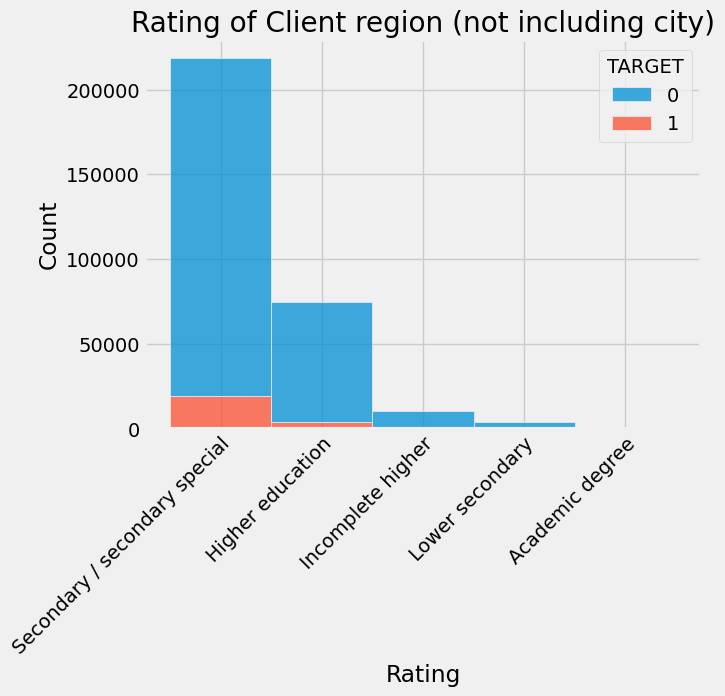

In [59]:
data = df_app_train_o.groupby('NAME_EDUCATION_TYPE')['SK_ID_CURR'].count().sort_values(ascending=False).reset_index()
educ_data = df_app_train_o[['NAME_EDUCATION_TYPE', 'TARGET']]
educ_data['NAME_EDUCATION_TYPE'] = pd.Categorical(educ_data['NAME_EDUCATION_TYPE'], data['NAME_EDUCATION_TYPE'].values.tolist())

plt.style.use('fivethirtyeight')
plt.xticks(rotation = 45, rotation_mode="anchor", ha="right")
sns.histplot(data=educ_data, x='NAME_EDUCATION_TYPE', hue='TARGET', multiple='stack')
plt.title('Rating of Client region (not including city)')
plt.xlabel('Rating')
plt.ylabel('Count')

In [60]:
educ_data = educ_data[['TARGET', 'NAME_EDUCATION_TYPE']]
educ_groups = educ_data.groupby('NAME_EDUCATION_TYPE').mean().sort_values(by='TARGET', ascending=False)
educ_groups

,TARGET
NAME_EDUCATION_TYPE,
Lower secondary,0.109277
Secondary / secondary special,0.089399
Incomplete higher,0.084850
Higher education,0.053551
Academic degree,0.018293


<Axes: xlabel='NAME_EDUCATION_TYPE'>

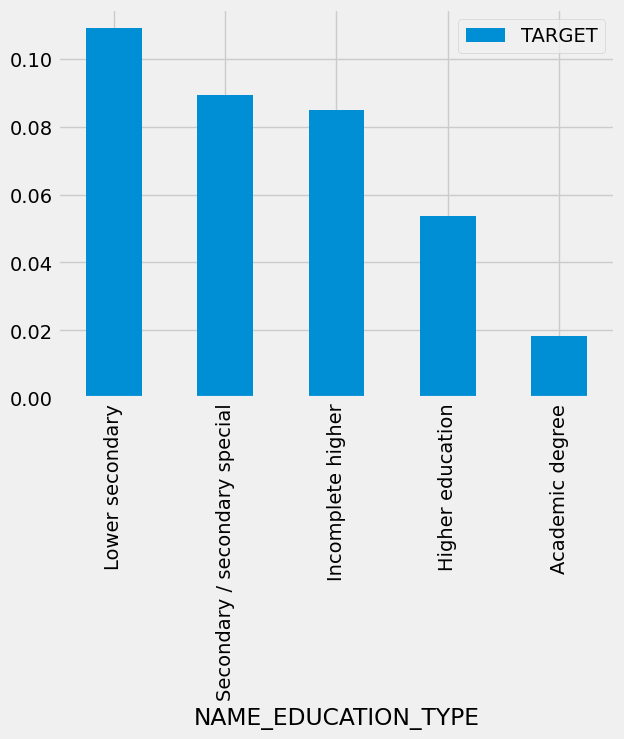

In [61]:
educ_groups.plot(kind='bar')

Ici pareil, plus un individus aura un niveau d'étude élevé, moins il y aura de chance qu'il fasse un defauts de remboursement.  
De la même façon, ce n'est pas une indication à discriminer, 9 individus sur 10 avec le niveau d'éducation le plus bas ne font pas de défaut de paiement, mais c'est une indication supplémentaire.

### EXT_SOURCE (1, 2, 3)

Ces 3 variables sont assez abstraites, on ne sait pas vraiement ce qu'elles représentent. Elles sont néamoins les variables avec les corrélations négatives les plus importantes et doivent être étudiées.

Text(0.5, 1.0, 'Correlation Heatmap')

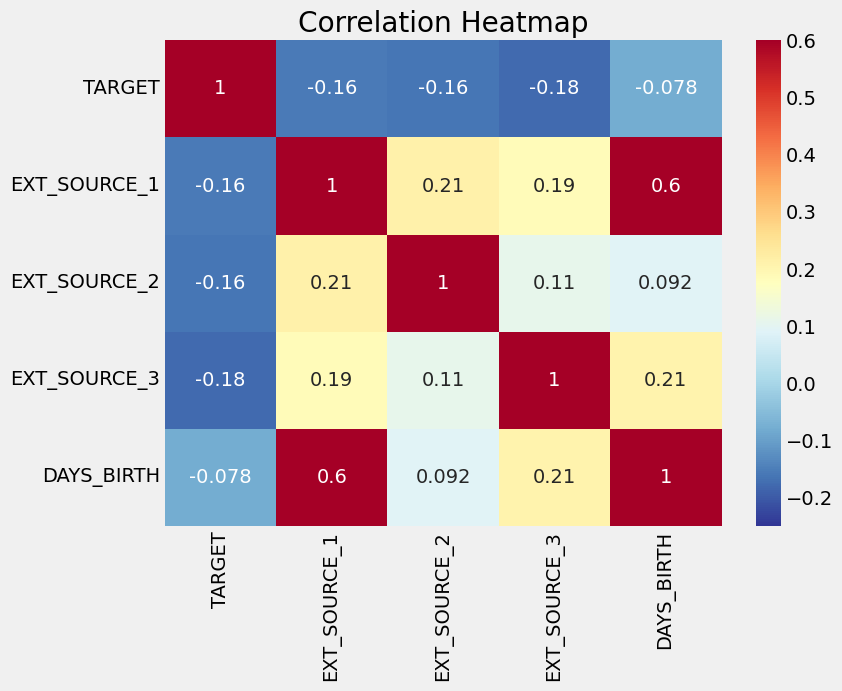

In [62]:
ext_data = df_app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

Comme nous l'avons vu, il y a une corrélation négative entre les 3 `EXT_SOURCE` et notre `TARGET`. Il y a aussi une assez importante corrélation entre l'age de l'individus, et `EXT_SOURCE_1`.  
Voyons leur distribution individuelle en rapport avec `TARGET` :

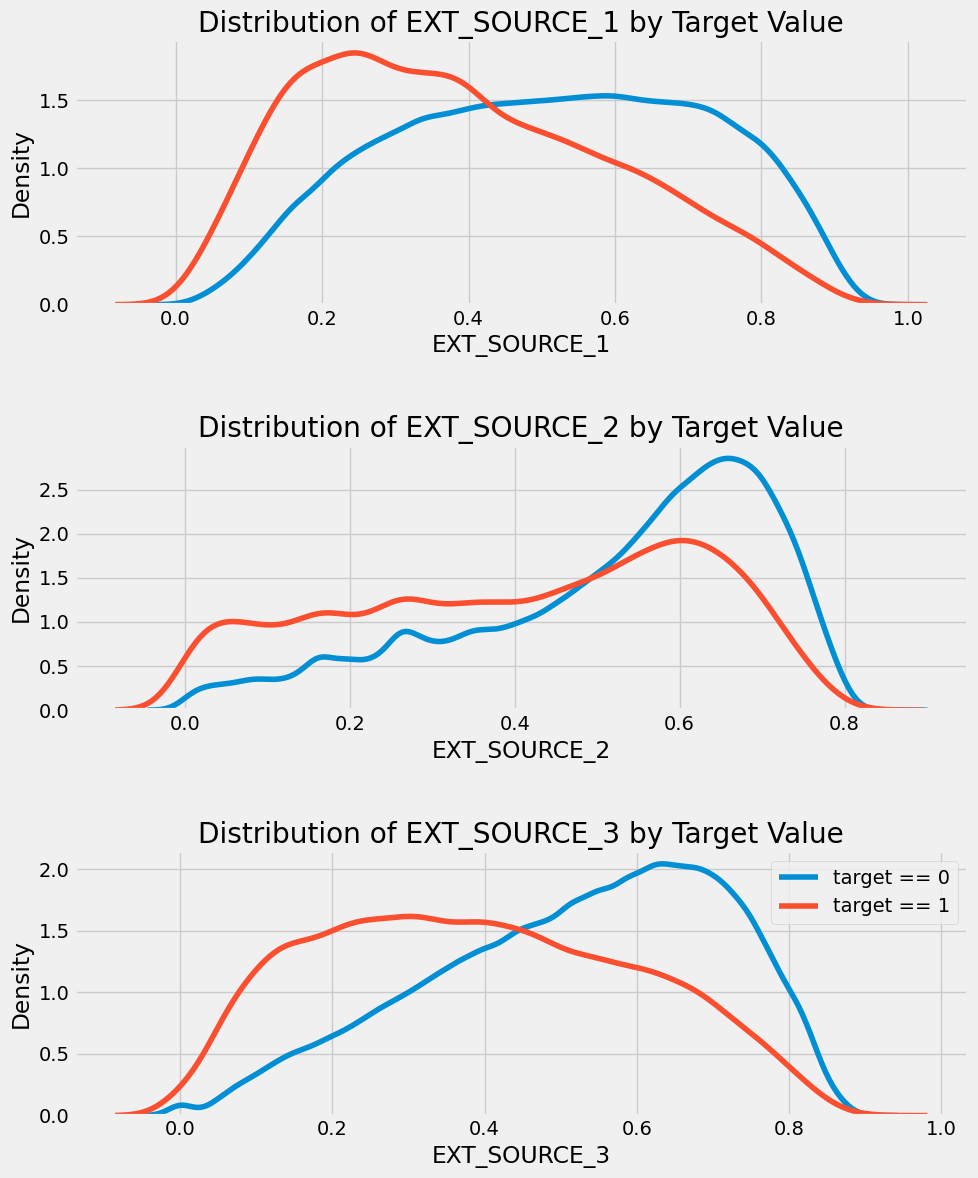

In [63]:
plt.figure(figsize = (10, 12))

for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    plt.subplot(3, 1, i + 1)
    sns.kdeplot(df_app_train.loc[df_app_train['TARGET'] == 0, source], label = 'target == 0')
    sns.kdeplot(df_app_train.loc[df_app_train['TARGET'] == 1, source], label = 'target == 1')
    plt.title(f'Distribution of {source} by Target Value')
    plt.xlabel(source)
    plt.ylabel('Density')
    
plt.legend()
plt.tight_layout(h_pad = 3)

Malgré leur faible corrélation à `TARGET`, on voit clairement une relation entre ces 3 variables et la capacité d'un individus à rembourser son pret à temps.

### AMT_GOODS_PRICE

Text(0, 0.5, 'Count')

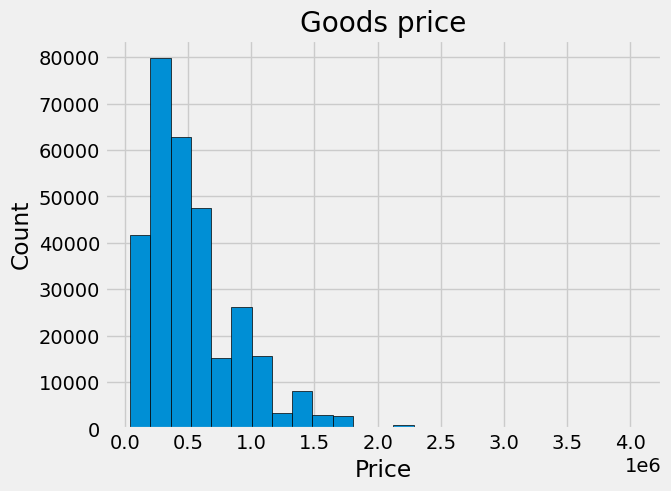

In [64]:
plt.style.use('fivethirtyeight')
plt.hist(df_app_train['AMT_GOODS_PRICE'], edgecolor = 'k', bins = 25)
plt.title('Goods price')
plt.xlabel('Price')
plt.ylabel('Count')

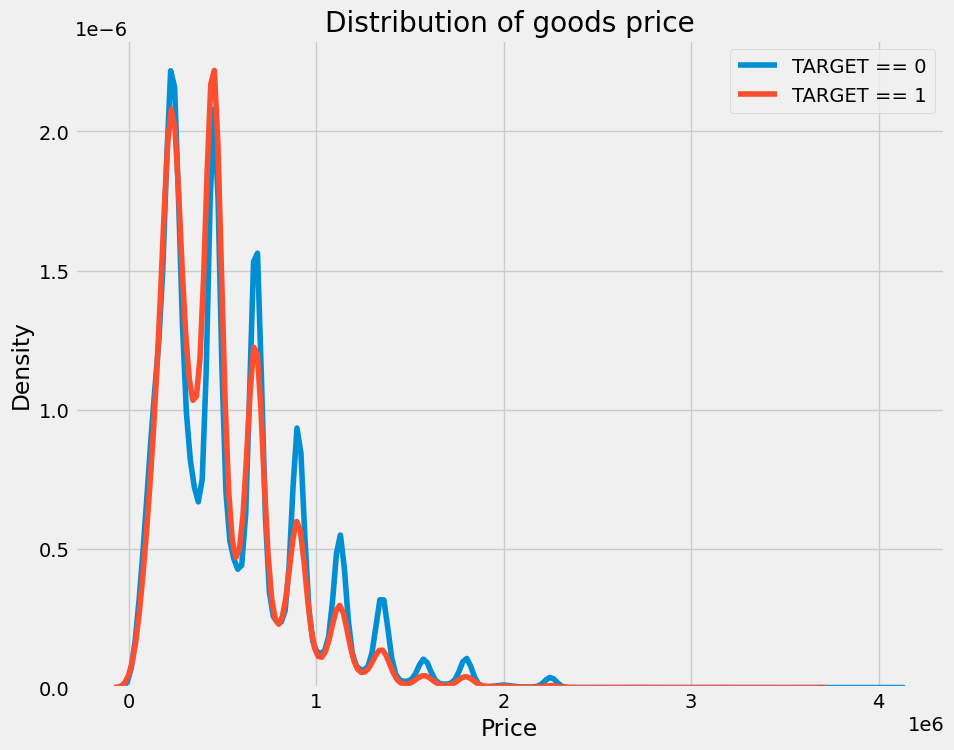

In [65]:
plt.figure(figsize = (10, 8))
sns.kdeplot(df_app_train.loc[df_app_train['TARGET'] == 0, 'AMT_GOODS_PRICE'], label = 'TARGET == 0')
sns.kdeplot(df_app_train.loc[df_app_train['TARGET'] == 1, 'AMT_GOODS_PRICE'], label = 'TARGET == 1')
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Distribution of goods price')
plt.legend()
plt.show()

# Feature Engineering
_______________________________________________________________________________________

## Simple manual feature engineering from main dataset

### Features Polynomiales

In [66]:
poly_features = df_app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = df_app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

poly_transformer = PolynomialFeatures(degree = 3)

In [67]:
poly_transformer.fit(poly_features)

poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [68]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

Nous avons maintenant 35 features, voyons lesquelles sont corrélé à `TARGET`

In [69]:
poly_features = pd.DataFrame(poly_features, 
                                columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


Certainnes de ces nouvelles features ont une corrélation plus forte que les feature originelles. Afin de tester plus tard la comparaison de ces featrues dans l'entrainement des modèles, nous allons les sauvgarder dans des dataframe séparés. L'imputation a peut 6etre joué un role a ces différences.

In [70]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                    columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

In [71]:
# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = df_app_train['SK_ID_CURR']
poly_features

,1,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2^2,...,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3,TARGET,SK_ID_CURR
0,1.0,0.083037,0.262949,0.139376,9461.0,0.006895,0.021834,0.011573,785.612741,0.069142,...,654.152155,0.005108,346.733025,2.353667e+07,0.002707,183.785667,1.247560e+07,8.468590e+11,1,100002
1,1.0,0.311267,0.622246,0.535276,16765.0,0.096887,0.193685,0.166614,5218.396558,0.387190,...,6491.237356,0.178286,5583.975256,1.748917e+08,0.153368,4803.518644,1.504475e+08,4.712058e+12,0,100003
2,1.0,0.505998,0.555912,0.729567,19046.0,0.256034,0.281290,0.369159,9637.237066,0.309038,...,5885.942278,0.295894,7724.580233,2.016572e+08,0.388325,10137.567947,2.646504e+08,6.908939e+12,0,100004
3,1.0,0.505998,0.650442,0.535276,19005.0,0.256034,0.329122,0.270849,9616.491150,0.423074,...,8040.529222,0.186365,6616.894583,2.349331e+08,0.153368,5445.324893,1.933364e+08,6.864416e+12,0,100006
4,1.0,0.505998,0.322738,0.535276,19932.0,0.256034,0.163305,0.270849,10085.551255,0.104160,...,2076.117194,0.092471,3443.335447,1.282190e+08,0.153368,5710.929533,2.126570e+08,7.918677e+12,0,100007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,1.0,0.145570,0.681632,0.535276,9327.0,0.021191,0.099226,0.077920,1357.735652,0.464623,...,4333.535427,0.195302,3403.064069,5.929719e+07,0.153368,2672.378073,4.656525e+07,8.113830e+11,0,456251
307507,1.0,0.505998,0.115992,0.535276,20775.0,0.256034,0.058692,0.270849,10512.107532,0.013454,...,279.510177,0.033234,1289.874004,5.006225e+07,0.153368,5952.466438,2.310256e+08,8.966503e+12,0,456252
307508,1.0,0.744026,0.535722,0.218859,14966.0,0.553575,0.398591,0.162837,11135.099439,0.286998,...,4295.209439,0.025661,1754.727189,1.199916e+08,0.010483,716.860854,4.902031e+07,3.352102e+12,0,456253
307509,1.0,0.505998,0.514163,0.661024,11961.0,0.256034,0.260165,0.334477,6052.241549,0.264363,...,3162.050920,0.224665,4065.229905,7.355897e+07,0.288836,5226.384584,9.456968e+07,1.711207e+12,1,456254


In [72]:
df_app_train[['SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
0,100002,0.083037,0.262949,0.139376,9461
1,100003,0.311267,0.622246,NaN,16765
2,100004,NaN,0.555912,0.729567,19046
3,100006,NaN,0.650442,NaN,19005
4,100007,NaN,0.322738,NaN,19932
...,...,...,...,...,...
307506,456251,0.145570,0.681632,NaN,9327
307507,456252,NaN,0.115992,NaN,20775
307508,456253,0.744026,0.535722,0.218859,14966
307509,456254,NaN,0.514163,0.661024,11961


In [73]:
#test_1 = df_app_train.head(1000)
#test_2 = poly_features.head(1000)
#
#print(test_1.shape)
#print(test_2.shape)
#df_test = test_1.join(test_2, how='left', rsuffix='_y')
#df_test.drop(df_test.filter(regex='_y$').columns, axis=1, inplace=True)
#df_test.shape
#df_test


In [74]:
#app_train_poly = df_app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left') <- this makes copy all over, really memory heavy, too much for my computer

df_app_train_poly = df_app_train.join(poly_features, how='left', rsuffix='_y')
df_app_train_poly.drop(df_app_train_poly.filter(regex='_y$').columns, axis=1, inplace=True)

# Merge polynomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = df_app_test['SK_ID_CURR']
df_app_test_poly = df_app_test.join(poly_features_test, how = 'left', rsuffix='_y')
df_app_test_poly.drop(df_app_test_poly.filter(regex='_y$').columns, axis=1, inplace=True)

# Align the dataframes
df_app_train_poly, df_app_test_poly = df_app_train_poly.align(df_app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', df_app_train_poly.shape)
print('Testing data with polynomial features shape:  ', df_app_test_poly.shape)

Training data with polynomial features shape:  (307511, 271)
Testing data with polynomial features shape:   (48744, 271)


Nous avons maintenant 2 nouveaux DF `app_train_poly` et `app_test_poly` contenant les features originelles + les features polynomiales. Nous les testerons plus tard.

### Features en rapport avec la connaissance du milieu

Même si ma connaissance en prêt bancaire, avec l'aide du notebook associé sur kaggle, nous pouvons essayer de créer des features utiles à partirs d'autres features en nous servant de notre intuition :
- `CREDIT_INCOME_PERCENT` : le % du credit total par rapport aux revenus
- `ANNUITY_INCOME_PERCENT` : le % du cout annuel du crédit par rapport aux revenus
- `CREDIT_TERM` : le temps (mois) du ccrédit
- `DAYS_EMPLOYED_PERCENT` : le rapport entre `DAYS_EMPLOYED` et l'age de l'individus

In [75]:
df_app_train_domain = df_app_train.copy()
df_app_test_domain = df_app_test.copy()

df_app_train_domain['CREDIT_INCOME_PERCENT'] = df_app_train_domain['AMT_CREDIT'] / df_app_train_domain['AMT_INCOME_TOTAL']
df_app_train_domain['ANNUITY_INCOME_PERCENT'] = df_app_train_domain['AMT_ANNUITY'] / df_app_train_domain['AMT_INCOME_TOTAL']
df_app_train_domain['CREDIT_TERM'] = df_app_train_domain['AMT_ANNUITY'] / df_app_train_domain['AMT_CREDIT']
df_app_train_domain['DAYS_EMPLOYED_PERCENT'] = df_app_train_domain['DAYS_EMPLOYED'] / df_app_train_domain['DAYS_BIRTH']

In [76]:
df_app_test_domain['CREDIT_INCOME_PERCENT'] = df_app_test_domain['AMT_CREDIT'] / df_app_test_domain['AMT_INCOME_TOTAL']
df_app_test_domain['ANNUITY_INCOME_PERCENT'] = df_app_test_domain['AMT_ANNUITY'] / df_app_test_domain['AMT_INCOME_TOTAL']
df_app_test_domain['CREDIT_TERM'] = df_app_test_domain['AMT_ANNUITY'] / df_app_test_domain['AMT_CREDIT']
df_app_test_domain['DAYS_EMPLOYED_PERCENT'] = df_app_test_domain['DAYS_EMPLOYED'] / df_app_test_domain['DAYS_BIRTH']

fusion poly + domain (pour plus tard)

In [77]:
#app_train_poly = df_app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left') <- this makes copy all over, really memory heavy, too much for my computer

df_app_train_poly_domain = df_app_train.join(poly_features, how='left', rsuffix='_y')
df_app_train_poly_domain.drop(df_app_train_poly_domain.filter(regex='_y$').columns, axis=1, inplace=True)

df_app_train_poly_domain = df_app_train_poly_domain.join(df_app_train_domain, how='left', rsuffix='_y')
df_app_train_poly_domain.drop(df_app_train_poly_domain.filter(regex='_y$').columns, axis=1, inplace=True)

# Merge polynomial features into testing dataframe
#poly_features_test['SK_ID_CURR'] = df_app_test['SK_ID_CURR']
df_app_test_poly_domain = df_app_test.join(poly_features_test, how = 'left', rsuffix='_y')
df_app_test_poly_domain.drop(df_app_test_poly_domain.filter(regex='_y$').columns, axis=1, inplace=True)

df_app_test_poly_domain = df_app_test_poly_domain.join(df_app_test_domain, how='left', rsuffix='_y')
df_app_test_poly_domain.drop(df_app_test_poly_domain.filter(regex='_y$').columns, axis=1, inplace=True)

# Align the dataframes
df_app_train_poly_domain, df_app_test_poly_domain = df_app_train_poly_domain.align(df_app_test_poly_domain, join = 'inner', axis = 1)

df_app_train_poly_domain['TARGET'] = df_app_train['TARGET']

# Print out the new shapes
print('Training data with polynomial features shape: ', df_app_train_poly_domain.shape)
print('Testing data with polynomial features shape:  ', df_app_test_poly_domain.shape)

Training data with polynomial features shape:  (307511, 276)
Testing data with polynomial features shape:   (48744, 275)


Graph Domain

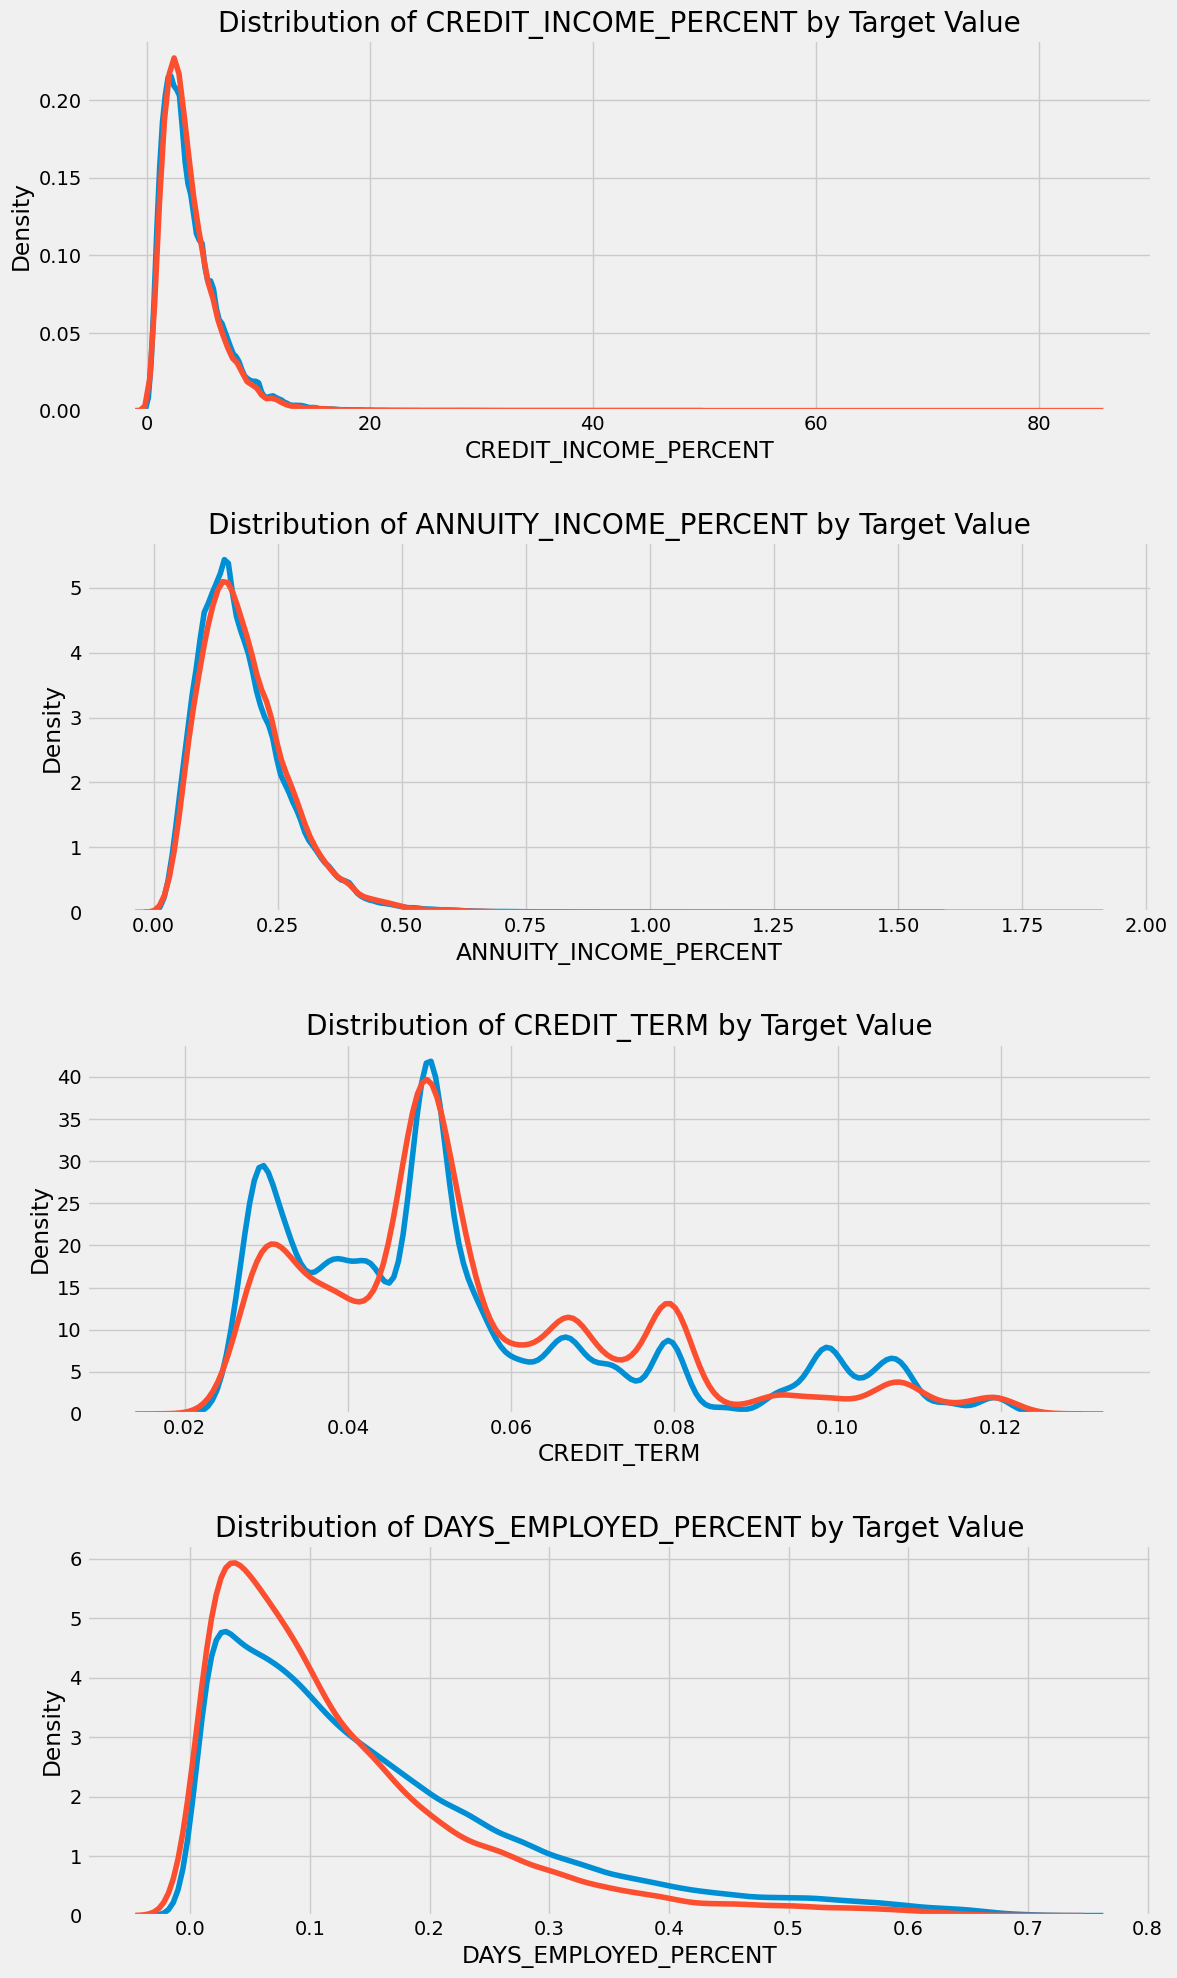

In [78]:
plt.figure(figsize = (12, 20))
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    plt.subplot(4, 1, i + 1)
    sns.kdeplot(df_app_train_domain.loc[df_app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    sns.kdeplot(df_app_train_domain.loc[df_app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

De même que pour les features polynomiales, nous gardons le couple originel + domain dans un autre DF pour tester plus tard.

# Export DataFrame
_______________________________________________________

In [79]:
if not os.path.exists('df_engineered') :
    os.mkdir('df_engineered')

df_app_train.to_csv('df_engineered/df_app_train.csv', index = False)
df_app_test.to_csv('df_engineered/df_app_test.csv', index = False)

df_app_train_poly.to_csv('df_engineered/df_app_train_poly.csv', index = False)
df_app_test_poly.to_csv('df_engineered/df_app_test_poly.csv', index = False)

df_app_train_domain.to_csv('df_engineered/df_app_train_domain.csv', index = False)
df_app_test_domain.to_csv('df_engineered/df_app_test_domain.csv', index = False)

df_app_train_poly_domain.to_csv('df_engineered/df_app_train_poly_domain.csv', index = False)
df_app_test_poly_domain.to_csv('df_engineered/df_app_test_poly_domain.csv', index = False)
